In [1]:
import os
dir = os.listdir('Apple PV/train')

print(dir)


['general_cedar_rust', 'general_scab', 'grey_spot', 'healthy', 'serious_cedar_rust', 'serious_scab']


In [2]:
import tensorflow as tf
import imageio
import numpy as np


def read_images(dir):

    supported_extensions = [".jpg", ".jpeg", ".png"]
    image_list = []
    count = 0
    # Walk through the directory and read images
    for root, _, files in os.walk(dir):
        for file in files:
            file_extension = os.path.splitext(file)[-1].lower()

            # Check if the file is a .jpg or .jpeg image
            if file_extension in supported_extensions:
                image_path = os.path.join(root, file)
                try:
                    image = imageio.imread(image_path)
                    image1 = image

                    image = np.asarray(image)
                    del image1
                    image_list.append(image)
                except Exception as e:
                    print(f"Error reading image {image_path}: {e}")

            count += 1

            if count % 100 == 0:
              print(str(count) + " images read")


    return image_list



2024-01-30 10:47:34.451249: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 10:47:34.477242: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 10:47:34.477267: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 10:47:34.477286: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 10:47:34.482375: I tensorflow/core/platform/cpu_feature_g

In [3]:
# @title
# Train data directories
base_train_dir = 'Apple PV/train'

general_cedar_rust_train = read_images(os.path.join(base_train_dir, 'general_cedar_rust'))
general_scab_train = read_images(os.path.join(base_train_dir, 'general_scab'))
grey_spot_train = read_images(os.path.join(base_train_dir, 'grey_spot'))
healthy_apple_train = read_images(os.path.join(base_train_dir, 'healthy'))
serious_cedar_rust_train = read_images(os.path.join(base_train_dir, 'serious_cedar_rust'))
serious_scab_train = read_images(os.path.join(base_train_dir, 'serious_scab'))

# Test data directories
base_test_dir = 'Apple PV/validation'

general_cedar_rust_test = read_images(os.path.join(base_test_dir, 'general_cedar_rust'))
general_scab_test = read_images(os.path.join(base_test_dir, 'general_scab'))
grey_spot_test = read_images(os.path.join(base_test_dir, 'grey_spot'))
healthy_test_2 = read_images(os.path.join(base_test_dir, 'healthy'))
serious_cedar_rust_test = read_images(os.path.join(base_test_dir, 'serious_cedar_rust'))
serious_scab_test = read_images(os.path.join(base_test_dir, 'serious_scab'))


/tmp/ipykernel_171603/817432282.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


100 images read
100 images read
100 images read
200 images read
300 images read
100 images read
200 images read
300 images read
400 images read
500 images read
600 images read
700 images read
800 images read
900 images read
100 images read
100 images read


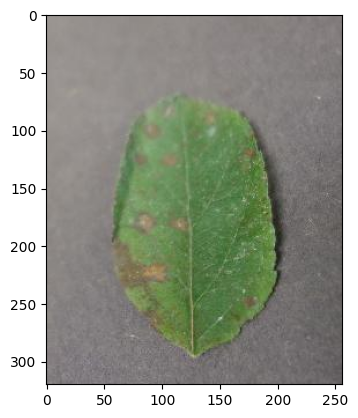

In [4]:
import matplotlib.pyplot as plt

imgplot = plt.imshow(general_cedar_rust_train[0])
plt.show()

In [5]:
# For training classes
print("Length of general_cedar_rust_train:", len(general_cedar_rust_train))
print("Length of general_scab_train:", len(general_scab_train))
print("Length of grey_spot_train:", len(grey_spot_train))
print("Length of healthy_apple_train:", len(healthy_apple_train))
print("Length of serious_cedar_rust_train:", len(serious_cedar_rust_train))
print("Length of serious_scab_train:", len(serious_scab_train))

# For test classes
print("Length of general_cedar_rust_test:", len(general_cedar_rust_test))
print("Length of general_scab_test:", len(general_scab_test))
print("Length of grey_spot_test:", len(grey_spot_test))
print("Length of healthy_test_2:", len(healthy_test_2))
print("Length of serious_cedar_rust_test:", len(serious_cedar_rust_test))
print("Length of serious_scab_test:", len(serious_scab_test))

# Calculate the lengths of all train parts
train_lengths = len(general_cedar_rust_train) + len(general_scab_train) + len(grey_spot_train) + len(healthy_apple_train) + len(serious_cedar_rust_train) + len(serious_scab_train)

# Calculate the lengths of all test parts
test_lengths = len(general_cedar_rust_test) + len(general_scab_test) + len(grey_spot_test) + len(healthy_test_2) + len(serious_cedar_rust_test) + len(serious_scab_test)

# Print the results
print("Total length of all train parts:", train_lengths)
print("Total length of all test parts:", test_lengths)

# Calculate the total length of all parts
total_length = train_lengths + test_lengths

# Print the results
print("Total length of all parts:", total_length)


Length of general_cedar_rust_train: 109
Length of general_scab_train: 164
Length of grey_spot_train: 331
Length of healthy_apple_train: 920
Length of serious_cedar_rust_train: 31
Length of serious_scab_train: 116
Length of general_cedar_rust_test: 20
Length of general_scab_test: 29
Length of grey_spot_test: 59
Length of healthy_test_2: 163
Length of serious_cedar_rust_test: 6
Length of serious_scab_test: 21
Total length of all train parts: 1671
Total length of all test parts: 298
Total length of all parts: 1969


In [6]:
import imgaug as ia
import imgaug.augmenters as iaa
import random
import copy

def add_gaussian_noise(images, mean_range=(0, 10), std_range=(0, 0.1)):
    ia.seed(1)
    # Define the augmentation pipeline
    seq = iaa.Sequential([
        iaa.AdditiveGaussianNoise(loc=mean_range, scale=(0, 0.2*255))
    ])

    # Convert images to numpy array (imgaug requires numpy arrays)
    # images_np = np.array(images)

    # Perform augmentation on each image individually
    augmented_images = [seq(image=image) for image in images]

    return augmented_images

def random_crop(images, crop_percent=(0.1, 0.4)):
    ia.seed(1)
    # Define the augmentation pipeline
    seq = iaa.Sequential([
        iaa.Crop(percent=crop_percent)
    ])

    # Convert images to numpy array (imgaug requires numpy arrays)
    # images_np = np.array(images)

    # Perform augmentation on each image individually
    augmented_images = [seq(image=image) for image in images]

    return augmented_images

def random_rotate(images, rotation_range=(-360, 360)):
    ia.seed(1)
    # Define the augmentation pipeline
    seq = iaa.Sequential([
        iaa.Rotate(rotate=rotation_range)
    ])

    # Convert images to numpy array (imgaug requires numpy arrays)
    # images_np = np.array(images)

    # Perform augmentation on each image individually
    augmented_images = [seq(image=image) for image in images]

    return augmented_images

def invert_images(images):
    ia.seed(1)
    # Define the augmentation pipeline
    seq = iaa.Sequential([
        iaa.Add(value=(-20, 20))
    ])

    # Convert images to numpy array (imgaug requires numpy arrays)
    # images_np = np.array(images)

    # Perform augmentation on each image individually
    augmented_images = [seq(image=image) for image in images]

    return augmented_images


def adjust_brightness(images, brightness_range=(-65, 65)):
    ia.seed(1)
    # Define the augmentation pipeline for adjusting brightness
    seq = iaa.Sequential([
        iaa.Multiply((1.0 + brightness_range[0] / 100.0, 1.0 + brightness_range[1] / 100.0))
    ])

    # Convert images to numpy array (imgaug requires numpy arrays)
    # images_np = np.array(images)

    # Perform augmentation on each image individually
    augmented_images = [seq(image=image) for image in images]

    return augmented_images


def scale_images(images, scale_factor = (0.3, 1.8)):
    ia.seed(1)
    # Define the augmentation pipeline for scaling images
    seq = iaa.Sequential([
        iaa.Affine(scale=scale_factor)
    ])

    # Convert images to numpy array (imgaug requires numpy arrays)
    # images_np = np.array(images)

    # Perform augmentation on each image individually
    augmented_images = [seq(image=image) for image in images]

    return augmented_images

# discard images according to ratio
def discard_images(images, discard_ratio=0.5):
    random.seed(10)
    # Calculate the number of images to discard based on the discard_ratio
    num_images_to_discard = int(len(images) * discard_ratio)

    # Create a copy of the input list to avoid modifying the original list
    remaining_images = images[:]

    # Randomly discard a portion of the images
    random.shuffle(remaining_images)
    remaining_images = remaining_images[num_images_to_discard:]

    return remaining_images




def resize_images(images_list, width=128, height=128):
    ia.seed(1)
    # Define the resize augmentation
    resize_augmenter = iaa.Resize({"height": height, "width": width})

    resized_images = []

    for image in images_list:
        # Ensure the image is in RGB format (imgaug uses RGB by default)
        if image.shape[-1] == 1:  # Grayscale image with single channel
            image = np.repeat(image, 3, axis=-1)

        # Apply the resize augmentation
        augmented_image = resize_augmenter.augment_image(image)

        # Append the augmented image to the result list
        resized_images.append(augmented_image)

    del images_list[:]
    return resized_images

def keep_n_images(images, n_to_keep):
    random.seed(10)
    if n_to_keep >= len(images):
        return images  # Keep all images if n_to_keep is greater than or equal to the image count

    # Randomly shuffle the images list
    random.shuffle(images)

    # Keep the first n_to_keep images and discard the rest
    kept_images = images[:n_to_keep]

    # Create a copy of the kept images list
    kept_images_copy = copy.deepcopy(kept_images)

    # Clear the original images list to free memory
    del images[:]

    return kept_images_copy
import cv2
def normalize_images(image_list):

  for i in range(len(image_list)):
      image = image_list[i].astype(np.float32) / 255.0
      image_list[i] = image

def discard_images(lst, percent_to_discard):
    # Randomly select images to discard using NumPy
    num_images_to_discard = int(len(lst) * percent_to_discard)
    indices_to_discard = np.random.choice(len(lst), size=num_images_to_discard, replace=False)

    # Create a new list without the discarded images
    modified_lst = np.delete(lst, indices_to_discard, axis=0)

    return list(modified_lst)


In [7]:
general_cedar_rust_noise = add_gaussian_noise(general_cedar_rust_train)
general_cedar_rust_crop = random_crop(general_cedar_rust_train)
general_cedar_rust_invert = invert_images(general_cedar_rust_train)
general_cedar_rust_bright = adjust_brightness(general_cedar_rust_train)
general_cedar_rust_scale = scale_images(general_cedar_rust_train)
general_cedar_rust_rotate = random_rotate(general_cedar_rust_train)


# Concatenate the lists
general_cedar_rust_all = (
    general_cedar_rust_noise +
    general_cedar_rust_crop +
    general_cedar_rust_invert +
    general_cedar_rust_bright +
    general_cedar_rust_scale +
    general_cedar_rust_rotate
)



# Process general_scab_train
general_scab_noise = add_gaussian_noise(general_scab_train)
general_scab_crop = random_crop(general_scab_train)
general_scab_invert = invert_images(general_scab_train)
general_scab_bright = adjust_brightness(general_scab_train)
general_scab_scale = scale_images(general_scab_train)
general_scab_rotate = random_rotate(general_scab_train)

general_scab_all = (
    general_scab_noise +
    general_scab_crop +
    general_scab_invert +
    general_scab_bright +
    general_scab_scale +
    general_scab_rotate
)



# Process grey_spot_train
grey_spot_noise = add_gaussian_noise(grey_spot_train)
grey_spot_crop = random_crop(grey_spot_train)
grey_spot_invert = invert_images(grey_spot_train)
grey_spot_bright = adjust_brightness(grey_spot_train)
grey_spot_scale = scale_images(grey_spot_train)
grey_spot_rotate = random_rotate(grey_spot_train)

grey_spot_all = (
    grey_spot_noise +
    grey_spot_crop +
    grey_spot_invert +
    grey_spot_bright +
    grey_spot_scale +
    grey_spot_rotate
)


# Process healthy_apple_train
healthy_apple_noise = add_gaussian_noise(healthy_apple_train)
healthy_apple_crop = random_crop(healthy_apple_train)
healthy_apple_invert = invert_images(healthy_apple_train)
healthy_apple_bright = adjust_brightness(healthy_apple_train)
healthy_apple_scale = scale_images(healthy_apple_train)
healthy_apple_rotate = random_rotate(healthy_apple_train)

healthy_apple_all = (
    healthy_apple_noise +
    healthy_apple_crop +
    healthy_apple_invert +
    healthy_apple_bright +
    healthy_apple_scale +
    healthy_apple_rotate
)


# Process serious_cedar_rust_train
serious_cedar_rust_noise = add_gaussian_noise(serious_cedar_rust_train)
serious_cedar_rust_crop = random_crop(serious_cedar_rust_train)
serious_cedar_rust_invert = invert_images(serious_cedar_rust_train)
serious_cedar_rust_bright = adjust_brightness(serious_cedar_rust_train)
serious_cedar_rust_scale = scale_images(serious_cedar_rust_train)
serious_cedar_rust_rotate = random_rotate(serious_cedar_rust_train)

serious_cedar_rust_all = (
    serious_cedar_rust_noise +
    serious_cedar_rust_crop +
    serious_cedar_rust_invert +
    serious_cedar_rust_bright +
    serious_cedar_rust_scale +
    serious_cedar_rust_rotate
)



# Process serious_scab_train
serious_scab_noise = add_gaussian_noise(serious_scab_train)
serious_scab_crop = random_crop(serious_scab_train)
serious_scab_invert = invert_images(serious_scab_train)
serious_scab_bright = adjust_brightness(serious_scab_train)
serious_scab_scale = scale_images(serious_scab_train)
serious_scab_rotate = random_rotate(serious_scab_train)

serious_scab_all = (
    serious_scab_noise +
    serious_scab_crop +
    serious_scab_invert +
    serious_scab_bright +
    serious_scab_scale +
    serious_scab_rotate
)




In [8]:
# # discard 40% augmented images
# percent_to_discard = 0.40
# general_cedar_rust_all = discard_images(general_cedar_rust_all, percent_to_discard)
# general_scab_all = discard_images(general_scab_all, percent_to_discard)
# grey_spot_all = discard_images(grey_spot_all, percent_to_discard)
# healthy_apple_all = discard_images(healthy_apple_all, percent_to_discard)
# serious_cedar_rust_all = discard_images(serious_cedar_rust_all, percent_to_discard)
# serious_scab_all = discard_images(serious_scab_all, percent_to_discard)


In [9]:
type(general_cedar_rust_all)

list

In [10]:


general_cedar_rust_train = general_cedar_rust_train + general_cedar_rust_all
general_scab_train = general_scab_train + general_scab_all
grey_spot_train = grey_spot_train + grey_spot_all
healthy_apple_train = healthy_apple_train + healthy_apple_all
serious_cedar_rust_train = serious_cedar_rust_train + serious_cedar_rust_all
serious_scab_train = serious_scab_train + serious_scab_all

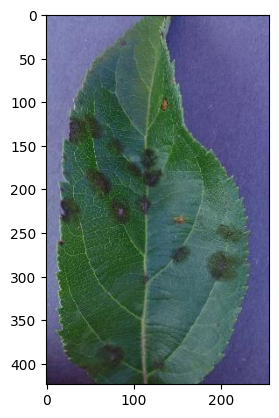

In [11]:
import matplotlib.pyplot as plt

imgplot = plt.imshow(serious_scab_train[100])
plt.show()

In [12]:
labels_healthy_apple_train = np.zeros(len(healthy_apple_train))
labels_general_scab_train = np.ones(len(general_scab_train))
labels_serious_scab_train = np.full(len(serious_scab_train), 2)
labels_grey_spot_train = np.full(len(grey_spot_train), 3)
labels_general_cedar_rust_train = np.full(len(general_cedar_rust_train),4)
labels_serious_cedar_rust_train = np.full(len(serious_cedar_rust_train), 5)

# Combine train labels
labels_train = np.concatenate([
    labels_general_cedar_rust_train,
    labels_general_scab_train,
    labels_grey_spot_train,
    labels_healthy_apple_train,
    labels_serious_cedar_rust_train,
    labels_serious_scab_train
])

labels_healthy_test_2 = np.zeros(len(healthy_test_2))
labels_general_scab_test = np.ones(len(general_scab_test))
labels_serious_scab_test = np.full(len(serious_scab_test), 2)
labels_grey_spot_test = np.full(len(grey_spot_test), 3)
labels_general_cedar_rust_test = np.full(len(general_cedar_rust_test),4)
labels_serious_cedar_rust_test = np.full(len(serious_cedar_rust_test), 5)


# Combine test labels
labels_test = np.concatenate([
    labels_general_cedar_rust_test,
    labels_general_scab_test,
    labels_grey_spot_test,
    labels_healthy_test_2,
    labels_serious_cedar_rust_test,
    labels_serious_scab_test
])


In [13]:
# Combine image datasets for training and testing
images_train = general_cedar_rust_train + general_scab_train + grey_spot_train + healthy_apple_train + serious_cedar_rust_train +serious_scab_train

images_test = general_cedar_rust_test + general_scab_test + grey_spot_test + healthy_test_2 + serious_cedar_rust_test + serious_scab_test

In [14]:
images_train = resize_images(images_train, 128,128)
images_test = resize_images(images_test, 128, 128)

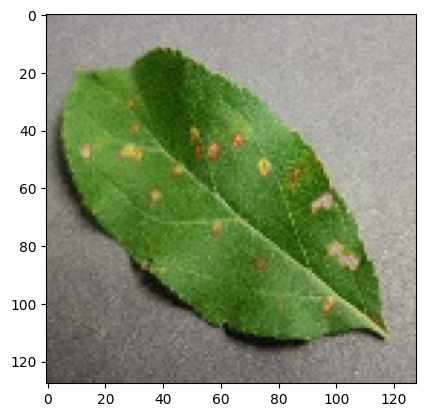

In [15]:
import matplotlib.pyplot as plt

imgplot = plt.imshow(images_train[174])
plt.show()

In [16]:

normalize_images(images_train)



In [17]:
images_train[80]

array([[[0.6666667 , 0.60784316, 0.61960787],
        [0.6666667 , 0.60784316, 0.61960787],
        [0.6666667 , 0.60784316, 0.61960787],
        ...,
        [0.6666667 , 0.61960787, 0.627451  ],
        [0.65882355, 0.6117647 , 0.61960787],
        [0.65882355, 0.6117647 , 0.61960787]],

       [[0.6666667 , 0.60784316, 0.61960787],
        [0.6627451 , 0.6039216 , 0.6156863 ],
        [0.6627451 , 0.6039216 , 0.6156863 ],
        ...,
        [0.654902  , 0.60784316, 0.6156863 ],
        [0.654902  , 0.60784316, 0.6156863 ],
        [0.654902  , 0.60784316, 0.6156863 ]],

       [[0.6784314 , 0.61960787, 0.6313726 ],
        [0.6745098 , 0.6156863 , 0.627451  ],
        [0.6784314 , 0.61960787, 0.6313726 ],
        ...,
        [0.6627451 , 0.6156863 , 0.62352943],
        [0.654902  , 0.60784316, 0.6156863 ],
        [0.64705884, 0.6       , 0.60784316]],

       ...,

       [[0.48235294, 0.4392157 , 0.45490196],
        [0.4745098 , 0.43137255, 0.44705883],
        [0.4509804 , 0

In [18]:
normalize_images(images_test)

In [19]:
#TEST Normalization

In [20]:
print(len(images_train))
print(len(labels_train))

counts = [0,0,0,0,0,0]

for label in labels_train:
    counts[int(label)] += 1

counts

11697
11697


[6440, 1148, 812, 2317, 763, 217]

In [21]:

ls1 = images_test
ls2 = images_train

images_test = np.array(images_test)
images_train = np.array(images_train)

del ls1[:]
del ls2[:]

shuffle_indices_train = np.random.permutation(len(images_train))
shuffle_indices_test = np.random.permutation(len(images_test))


images_train = images_train[shuffle_indices_train]
labels_train = labels_train[shuffle_indices_train]

images_test = images_test[shuffle_indices_test]
labels_test = labels_test[shuffle_indices_test]

In [22]:
# %load custom_callback.py
import tensorflow as tf
import numpy as np
import pandas as pd

# Find accuracy of model
def find_accuracy(test,pred):
    correct = 0
    total = len(test)

    for i in range(len(test)):
        if test[i] == pred[i]:
            correct += 1

    return correct/total


# Map ANN outputs to classes
def get_labels(y_pred_ann):
    labels = []

    for pred in y_pred_ann:
        max_index = 0

        for i in range(len(pred)):
            if pred[i] > pred[max_index]:
                max_index = i

        labels.append(max_index)

    return labels

# This callback prints accuracy by epoch information after each epoch
class Save_Accuracy_By_Epoch(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.X_Test = test_data[0]
        self.Y_Test = test_data[1]
        self.accuracies = []
        self.epochs = []

    def on_epoch_end(self, epoch, logs = None):
        y_pred = self.model.predict(self.X_Test)

        if epoch == 4:
            pass

        y_pred = get_labels(y_pred)
        accuracy = find_accuracy(self.Y_Test, y_pred)
        self.epochs.append(epoch+1)
        self.accuracies.append(accuracy)



        print(self.epochs)
        print(self.accuracies)


# This callback prints metrics for every class after each epoch
class Save_Multiclass_Metrics_By_Epoch(tf.keras.callbacks.Callback):
    def __init__(self, test_data, n_classes, save_after = 10, save_csv_path = 'results.csv', model_name = 'model.keras', decay_rate = 0.9, decay_after_epochs = 10, min_rate = 0.000032, save_folder_name = "."):
        self.X_Test = test_data[0]
        self.Y_Test = test_data[1]

        self.min_rate = min_rate;
        
        self.epochs = []
        self.n_classes = n_classes
        self.save_after = save_after
        self.save_csv_path = save_csv_path
        self.save_folder_name = save_folder_name
        self.model_name = model_name
        self.max_accuracy = 0
        self.decay_rate = decay_rate
        self.decay_after_epochs = decay_after_epochs

        self.mat_sensitivity = []
        self.mat_specificity = []
        self.mat_precision = []
        self.mat_recall = []
        self.mat_accuracy = []
        self.mat_f1 = []
        self.accuracies = []


        for i in range(n_classes):
            self.mat_sensitivity.append([])
            self.mat_specificity.append([])
            self.mat_precision.append([])
            self.mat_recall.append([])
            self.mat_accuracy.append([])
            self.mat_f1.append([])


    def on_epoch_end(self, epoch, logs = None):
        y_pred = self.model.predict(self.X_Test)
        y_pred = get_labels(y_pred)

        total = len(self.Y_Test)

        correct = 0
        for i in range(len(y_pred)):
            if y_pred[i] == self.Y_Test[i]:
                correct += 1

        accuracy = correct/total
        self.accuracies.append(correct / total)

        best = False

        if accuracy >= self.max_accuracy:
            self.max_accuracy = accuracy
            best = True


        if accuracy > 0.95:
          best = True

        for i in range(self.n_classes):
            TP = 0
            FP = 0
            TN = 0
            FN = 0

            for j in range(len(y_pred)):
                if self.Y_Test[j] == i and y_pred[j] == i:
                    TP += 1
                elif self.Y_Test[j] != i and y_pred[j] == i:
                    FP += 1
                elif self.Y_Test[j] == i and y_pred[j] != i:
                    FN += 1
                elif self.Y_Test[j] != i and y_pred[j] != i:
                    TN += 1

            sensitivity = TP / (TP + FN) if (TP + FN) > 0 else -1
            specificity = TN / (TN + FP) if (TN + FP) > 0 else -1
            precision = TP / (TP + FP) if (TP + FP) > 0 else -1
            recall = TP / (TP + FN) if (TP + FN) > 0 else -1
            accuracy = (TP + TN) / (TP + FN + TN + FP)
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else -1

            self.mat_sensitivity[i].append(sensitivity)
            self.mat_specificity[i].append(specificity)
            self.mat_precision[i].append(precision)
            self.mat_recall[i].append(recall)
            self.mat_accuracy[i].append(accuracy)
            self.mat_f1[i].append(f1)

        self.epochs.append(int(epoch+1))


        if (epoch + 1) % self.decay_after_epochs == 0 and self.model.optimizer.learning_rate > self.min_rate :
           from keras import backend as K
           print('learning rate changed from ', end = '')
           print(self.model.optimizer.learning_rate, end = '')
           K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.decay_rate)
           print(' to ', end = '')
           print(self.model.optimizer.learning_rate.numpy)

        if (epoch + 1) % self.save_after == 0:
            save_to_csv_file(self.save_csv_path, self.mat_sensitivity, self.mat_specificity, self.mat_precision, self.mat_recall, self.mat_accuracy, self.mat_f1, self.accuracies, self.epochs)
            self.model.save(self.model_name)
            print("max Accuracy: ", self.max_accuracy, "Learning Rate: ",self.model.optimizer.learning_rate.numpy())
            if best:
                self.model.save(self.save_folder_name + "/epoch" + str((epoch+1)) + "_" + self.model_name)
            pass

def save_to_csv_file(path, mat_sensitivity, mat_specificity, mat_precision, mat_recall, mat_accuracy, mat_f1, accuracies, epochs):
    mat_sensitivity = np.transpose(mat_sensitivity)
    mat_specificity = np.transpose(mat_specificity)
    mat_precision = np.transpose(mat_precision)
    mat_recall = np.transpose(mat_recall)
    mat_accuracy = np.transpose(mat_accuracy)
    mat_f1 = np.transpose(mat_f1)
    accuracies = np.reshape(accuracies, (-1,1))
    epochs = np.reshape(epochs, (-1,1))

    mat_join = np.concatenate((epochs,accuracies,mat_sensitivity, mat_specificity, mat_precision, mat_recall, mat_accuracy, mat_f1), axis = 1)

    n = mat_sensitivity.shape[1]


    col_array_sensitivity = list(range(n))
    col_array_specificity = list(range(n))
    col_array_precision = list(range(n))
    col_array_recall = list(range(n))
    col_array_accuracy = list(range(n))
    col_array_f1 = list(range(n))


    for i in range(n):
        col_array_sensitivity[i] = 'sensitivity Class ' + str(col_array_sensitivity[i])
        col_array_specificity[i] = 'specificity Class ' + str(col_array_specificity[i])
        col_array_precision[i] = 'precision Class ' + str(col_array_precision[i])
        col_array_recall[i] = 'recall Class ' + str(col_array_recall[i])
        col_array_accuracy[i] = 'accuracy Class ' + str(col_array_accuracy[i])
        col_array_f1[i] = 'f1 Class ' + str(col_array_f1[i])

    cols = ['Epoch']+['overall_accuracy']+ col_array_sensitivity + col_array_specificity + col_array_precision + col_array_recall + col_array_accuracy + col_array_f1

    mat_join = np.flip(mat_join, axis = 0)



    df = pd.DataFrame(
        columns = cols,
        data  = mat_join
    )

    df.to_csv(path, index= False)


In [23]:
# One hot encoding
labels_train_encoded = []
for label in labels_train:
    encoding = [0,0,0,0,0,0]
    encoding[int(label)] = 1
    labels_train_encoded.append(encoding)

labels_train_encoded = np.array(labels_train_encoded)

labels_test_encoded = []
for label in labels_test:
    encoding = [0,0,0,0,0,0]
    encoding[int(label)] = 1
    labels_test_encoded.append(encoding)

labels_test_encoded = np.array(labels_test_encoded)


In [30]:
model = tf.keras.models.Sequential()

raw_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128,3),
    pooling=None
)


model.add(raw_model)


model.add(tf.keras.layers.Dense(6, activation='softmax'))



In [31]:

# class_weights = [2.18, 1.459, 0.719, 0.259, 7.64, 2.0459]
# [cedar rust, general scab, grey spot, healthy, serious cedar rust, serious scab]

#[healthy, general scab, serious scab, grey spot, genral cedar rust, serious cedar rust]
# class_weights = [0.259, 1.459, 2.0459, 0.719, 2.18, 7.64]



loss = tf.keras.losses.CategoricalFocalCrossentropy(
    alpha=0.25,
    gamma=0.1,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    name='categorical_focal_crossentropy'
)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)


opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# loss = tf.keras.losses.CategoricalCrossentropy()

tf.keras.utils.set_random_seed(2)

model.summary()
model.compile(optimizer=opt, loss=loss, metrics = ['acc'])
# model.compile(optimizer='adam', loss=loss, metrics = ['acc'], loss_weights=class_weights)



2024-01-30 10:47:50.401942: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 64)                167520    
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 batch_normalization_15 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_16 (Ba  (None, 256)               1024      
 tchNormalization)                                      

In [ ]:
history = model.fit(images_train, labels_train_encoded, batch_size=128, epochs=500, validation_data=(images_test, labels_test_encoded), callbacks=[Save_Multiclass_Metrics_By_Epoch((images_test,labels_test), n_classes=4, save_after=1, save_csv_path="results_apple_model_part1.csv", model_name="apple_model_part1.keras",   decay_after_epochs = 1000, decay_rate = 0.9, save_folder_name="check", min_rate=0.00003)])


Epoch 1/500


2024-01-30 10:47:54.277489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-01-30 10:47:54.338919: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-30 10:47:56.740753: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd1a4904940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-30 10:47:56.740774: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-01-30 10:47:56.743965: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-30 10:47:56.833364: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 1s 21ms/stepss: 0.2674 - acc: 
max Accuracy:  0.5469798657718121 Learning Rate:  0.001
92/92 [==============================] - 19s 105ms/step - loss: 0.2674 - acc: 0.6524 - val_loss: 0.3174 - val_acc: 0.5470
Epoch 2/500
10/10 [==============================] - 0s 8ms/steposs: 0.1854 - acc: 0.
max Accuracy:  0.6006711409395973 Learning Rate:  0.001
92/92 [==============================] - 7s 76ms/step - loss: 0.1856 - acc: 0.7580 - val_loss: 0.3022 - val_acc: 0.6007
Epoch 3/500
10/10 [==============================] - 0s 8ms/steposs: 0.1559 - acc: 0.
max Accuracy:  0.6543624161073825 Learning Rate:  0.001
92/92 [==============================] - 7s 76ms/step - loss: 0.1558 - acc: 0.7983 - val_loss: 0.2369 - val_acc: 0.6544
Epoch 4/500
10/10 [==============================] - 0s 8ms/steposs: 0.1366 - acc: 0.
max Accuracy:  0.7751677852348994 Learning Rate:  0.001
92/92 [==============================] - 7s 76ms/step - loss: 0.1366 - acc: 0.8204 -

In [ ]:
# from keras import backend as K
# K.set_value(model.optimizer.learning_rate, 0.0001)